# 以 VGG16 為例，來示範 Transfer Learning 的作法

In [1]:
import warnings
warnings.filterwarnings('ignore')

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping, ModelCheckpoint

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from utils import load_data, load_test_data
from utils import num_classes, epochs, batch_size

Using TensorFlow backend.


In [2]:
X_train, y_train, X_valid, y_valid = load_data(Gray2RGB=True, mean_proc='VGG16_ImageNet', img_size=224)

## 讀取 pretrain model 可選擇要不要使用它末端的 dense layers

* include_top = True，會沿用 pre-trained model 後端的全連接層
* include_top = False，只會留 pre-trained model 的 CNN 層

## Fine Tuning & Layer Transfer

* Fine tuning：不鎖 layers，pre-trained model 的每一層都可以再訓練
* Layer transfer：鎖住 pre-trained model 的 layers，只訓練自己額外加的 dense layers

實務上 fine tuning 跟 layer transfer 不會分這麼清楚，不一定會全鎖或全不鎖，你可能會留 CNN 的後面幾層是可以訓練的，但鎖住前面幾層做特徵萃取器。

# Fine Tuning 實例

In [3]:
# 此例完全不鎖層，充分的 fine tuning
model_name = 'VGG16-Fine-Tune'

img_rows, img_cols, img_channel = 224, 224, 3

base_model = keras.applications.vgg16.VGG16(weights='imagenet', include_top=False,
                                            input_shape=(img_rows, img_cols, img_channel))
# for layer in base_model.layers:
#     layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [4]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-6)

model_path = './saved_models/{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop])

Epoch 1/100
70/70 [==============================] - 36s 516ms/step - loss: 2.8127 - acc: 0.0805 - val_loss: 2.6246 - val_acc: 0.1272

Epoch 00001: val_loss improved from inf to 2.62462, saving model to ./saved_models/VGG16-Fine-Tune.h5
Epoch 2/100
70/70 [==============================] - 30s 425ms/step - loss: 2.5271 - acc: 0.1626 - val_loss: 2.2174 - val_acc: 0.2838

Epoch 00002: val_loss improved from 2.62462 to 2.21740, saving model to ./saved_models/VGG16-Fine-Tune.h5
Epoch 3/100
70/70 [==============================] - 30s 426ms/step - loss: 2.2466 - acc: 0.2444 - val_loss: 2.0083 - val_acc: 0.3173

Epoch 00003: val_loss improved from 2.21740 to 2.00826, saving model to ./saved_models/VGG16-Fine-Tune.h5
Epoch 4/100
70/70 [==============================] - 30s 425ms/step - loss: 2.1739 - acc: 0.2555 - val_loss: 1.8964 - val_acc: 0.3896

Epoch 00004: val_loss improved from 2.00826 to 1.89641, saving model to ./saved_models/VGG16-Fine-Tune.h5
Epoch 5/100
70/70 [=====================

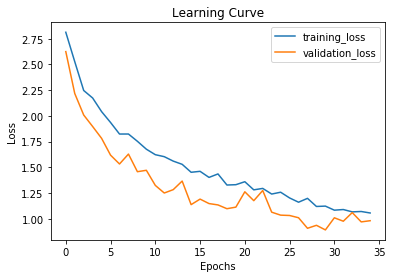

In [5]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

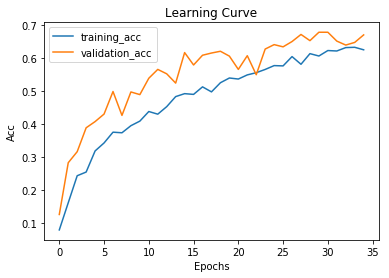

In [6]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [7]:
model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

747/747 [==============================] - 3s 5ms/step
Validation loss: 0.8912122543237934
Validation accuracy: 0.6787148597569191


In [8]:
X_test, X_id = load_test_data(Gray2RGB=True, mean_proc='VGG16_ImageNet')

y_test_pred_prob = model.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./submissions/{}.csv'.format(model_name), index=False)

# Layer Transfer 實例

In [9]:
# 此例的 VGG pre-trained layers 完全鎖住，充分的 layer transfer
model_name = 'VGG16-Layer-Transfer'

img_rows, img_cols, img_channel = 224, 224, 3

base_model = keras.applications.vgg16.VGG16(weights='imagenet',
                                            include_top=False, input_shape=(img_rows, img_cols, img_channel))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=predictions)

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [10]:
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

optimizer = keras.optimizers.Adam(lr=10e-5)

model_path = './saved_models/{}.h5'.format(model_name)

checkpoint = ModelCheckpoint(model_path, monitor='val_loss', save_best_only=True, verbose=1)
earlystop = EarlyStopping(monitor='val_loss', patience=5, verbose=1)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, metrics=['accuracy'])

model_history = model.fit_generator(datagen.flow(X_train, y_train, batch_size = batch_size),
                                    epochs = epochs,
                                    validation_data = (X_valid, y_valid),
                                    callbacks = [checkpoint, earlystop])

Epoch 1/100
70/70 [==============================] - 15s 219ms/step - loss: 2.3610 - acc: 0.2510 - val_loss: 1.4492 - val_acc: 0.6359

Epoch 00001: val_loss improved from inf to 1.44915, saving model to ./saved_models/VGG16-Layer-Transfer.h5
Epoch 2/100
70/70 [==============================] - 14s 194ms/step - loss: 1.5251 - acc: 0.4977 - val_loss: 1.0082 - val_acc: 0.7523

Epoch 00002: val_loss improved from 1.44915 to 1.00815, saving model to ./saved_models/VGG16-Layer-Transfer.h5
Epoch 3/100
70/70 [==============================] - 14s 193ms/step - loss: 1.2177 - acc: 0.6055 - val_loss: 0.8407 - val_acc: 0.7390

Epoch 00003: val_loss improved from 1.00815 to 0.84074, saving model to ./saved_models/VGG16-Layer-Transfer.h5
Epoch 4/100
70/70 [==============================] - 13s 192ms/step - loss: 1.0339 - acc: 0.6662 - val_loss: 0.7086 - val_acc: 0.7871

Epoch 00004: val_loss improved from 0.84074 to 0.70857, saving model to ./saved_models/VGG16-Layer-Transfer.h5
Epoch 5/100
70/70 [=

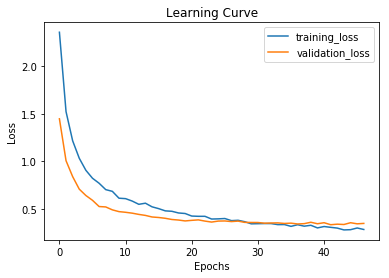

In [11]:
training_loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.plot(training_loss, label="training_loss")
plt.plot(val_loss, label="validation_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

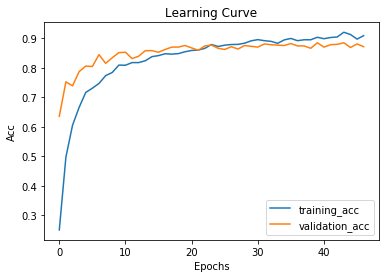

In [12]:
training_acc = model_history.history['acc']
val_acc = model_history.history['val_acc']

plt.plot(training_acc, label="training_acc")
plt.plot(val_acc, label="validation_acc")
plt.xlabel("Epochs")
plt.ylabel("Acc")
plt.title("Learning Curve")
plt.legend(loc='best')
plt.show()

In [13]:
model = load_model(model_path)

scores = model.evaluate(X_valid, y_valid, verbose=1)
print('Validation loss:', scores[0])
print('Validation accuracy:', scores[1])

747/747 [==============================] - 4s 5ms/step
Validation loss: 0.3342256772430387
Validation accuracy: 0.8781793846024407


In [14]:
X_test, X_id = load_test_data(Gray2RGB=True, mean_proc='VGG16_ImageNet')

y_test_pred_prob = model.predict(X_test)
y_test_pred = y_test_pred_prob.argmax(axis=-1)
y_test_pred_df = pd.DataFrame({'id': np.array(X_id), 'class':y_test_pred}).sort_values(by='id')
y_test_pred_df.to_csv('./submissions/{}.csv'.format(model_name), index=False)